In [1]:
# Importar bibliotecas necesarias
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
def preprocess_signal(signal):
    
    # Seleccionamos un objetivo de Ruido.
    Obj_snr_db = 10
    # Calculamos el poder de la señal y la pasamos a dB
    # Necesitamos calcular la potencia, en este caso sería:
    x_watts = signal ** 2
    
    #Antes de sacar las características, se le añade ruido en el siguiente fragmento de código.
    # --------------        
    sig_avg_watts = np.mean(x_watts)
    sig_avg_db = 10 * np.log10(sig_avg_watts)
    # Calculate noise according to [2] then convert to watts
    noise_avg_db = sig_avg_db - Obj_snr_db
    noise_avg_watts = 10 ** (noise_avg_db / 10)
    # Generamos una muestra de ruido blanco.
    mean_noise = 0
    noise_volts = np.random.normal(mean_noise, np.sqrt(noise_avg_watts), len(x_watts))
    # Sumamos el ruido a la señal
    signal_20dB = signal + noise_volts
    # -------------- 
    
    # Parámetros teóricos
    max_theoretical_value = 230 * np.sqrt(2)

    # Media de la señal
    mean_value = np.mean(signal_20dB)

    # Datos sin sesgo
    unbias_data = signal - mean_value
    unbias_data_2 = unbias_data ** 2
    unbias_data_3 = unbias_data_2 * unbias_data
    unbias_data_4 = unbias_data_3 * unbias_data

    # Cálculo de características
    variance = np.var(unbias_data)  # Varianza
    skewness = np.mean(unbias_data_3) / (variance ** 1.5)  # Asimetría
    kurtosis = np.mean(unbias_data_4) / (variance ** 2) - 3  # Curtosis
    thd = np.sqrt(np.sum(np.abs(np.fft.fft(signal_20dB)[2:4])) / np.abs(np.fft.fft(signal_20dB)[1]))  # Distorsión armónica total
    rms = np.sqrt(np.mean(signal_20dB ** 2))  # Valor RMS
    crest_factor = np.max(signal_20dB) / rms  # Factor de cresta

    # Devuelve todas las características en un vector
    return np.array([variance, skewness, kurtosis, thd, crest_factor])

def load_signal(data_path):

    # Asignar etiquetas explícitamente
    label_mapping = {
        "flicker_signals": 0,
        "harmonic_signals": 1,
        "interruption_signals": 2,
        "original_signals": 3,
        "sag_signals": 4,
        "swell_signals": 5,
        "transient_signals": 6,
        "harmonic_sag_signals": 7,
        "harmonic_swell_signals": 8,
        "Harmonic_interruption_signals": 9,
    }

    # Inicialización de listas para características y etiquetas
    features = []
    labels = []

    # Iterar por cada tipo de perturbación
    for signal_type, label in label_mapping.items():
        signal_type_path = os.path.join(data_path, signal_type)

        if os.path.isdir(signal_type_path):
            for subset in ["train", "test", "val"]:
                subset_path = os.path.join(signal_type_path, subset)

                if os.path.exists(subset_path):
                    for filename in os.listdir(subset_path):
                        if filename.endswith(".npy"):
                            file_path = os.path.join(subset_path, filename)

                            # Cargar la señal
                            signal = np.load(file_path)

                            # Procesar la señal y extraer características
                            feature_vector = preprocess_signal(signal)

                            # Agregar las características y etiquetas a las listas
                            features.append(feature_vector)
                            labels.append(label)

    return np.array(features), np.array(labels)

# Ejemplo de uso
data_path = "data"  # Ajusta esta ruta según sea necesario
features, labels = load_signal(data_path)

print(f"Características extraídas: {features.shape}")
print(f"Etiquetas extraídas: {labels.shape}")


# Contar las etiquetas únicas en los datos originales 
unique_labels, counts = np.unique(labels, return_counts=True)
print("Etiquetas únicas:", unique_labels)
print("Distribución de señales por categoría:")
for label, count in zip(unique_labels, counts):
    print(f"Clase {label}: {count} señales")

# Verificar que la clase 3 está presente
if 3 not in unique_labels: 
    print("Error: La clase 3 no está presente en los datos originales.")

Características extraídas: (108000, 5)
Etiquetas extraídas: (108000,)
Etiquetas únicas: [0 1 2 3 4 5 6 7 8 9]
Distribución de señales por categoría:
Clase 0: 10800 señales
Clase 1: 10800 señales
Clase 2: 10800 señales
Clase 3: 10800 señales
Clase 4: 10800 señales
Clase 5: 10800 señales
Clase 6: 10800 señales
Clase 7: 10800 señales
Clase 8: 10800 señales
Clase 9: 10800 señales


In [3]:
# Dividir los datos en conjunto de entrenamiento y prueba
# Random estate 42 es lo que he encontrado en varios articulos y ejemplos, realmente es poner un número aleatorio.
# Importante poner "stratify=labels", si no, puede haber problemas de separación de datos, no se cargan los datos de manera equitatva.
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42, stratify=labels)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Definir los rangos de hiperparámetros
# C is a hyper parameter that controls the regularization strength
# Gamma determina la curvatura del límite de decisión. Desempeña un papel fundamental a la hora de decidir cuánta flexibilidad o rigidez debe tener el límite. Una Gamma más baja da como resultado un límite más suave y menos complejo, mientras que una Gamma más alta introduce más complejidades.

param_grid = {
    'C': [0.1, 1, 10, 100],       # Valores bajos a altos de C
    'gamma': ['scale', 'auto', 0.01, 0.1, 1],  # Gamma ajustado
    'kernel': ['rbf']             # Mantener kernel RBF(Radial Basic Function)
}

# Crear el modelo SVM
svm = SVC()

# Configurar búsqueda en cuadrícula
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, scoring='accuracy')

# Entrenar el modelo y realizar búsqueda de hiperparámetros
grid_search.fit(X_train, y_train)

# Mostrar los mejores hiperparámetros y rendimiento
print("Mejores parámetros:", grid_search.best_params_)
print("Mejor puntuación (validación cruzada):", grid_search.best_score_)

# Usar el mejor modelo para predicciones
best_svm = grid_search.best_estimator_
predicciones = best_svm.predict(X_test)

# Calcular métricas
accuracy = accuracy_score(y_test, predicciones)
print(f"Accuracy en el conjunto de prueba: {accuracy:.2f}")

# Generar el informe de clasificación
print("\nReporte de Clasificación:")
print(classification_report(y_test, predicciones))

Mejores parámetros: {'C': 100, 'gamma': 1, 'kernel': 'rbf'}
Mejor puntuación (validación cruzada): 0.8339814814814815
Accuracy en el conjunto de prueba: 0.84

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      2160
           1       0.79      0.73      0.76      2160
           2       0.79      0.98      0.88      2160
           3       0.95      1.00      0.97      2160
           4       0.74      0.67      0.70      2160
           5       0.77      0.61      0.68      2160
           6       0.98      0.89      0.93      2160
           7       0.70      0.64      0.67      2160
           8       0.71      0.87      0.78      2160
           9       0.99      0.99      0.99      2160

    accuracy                           0.84     21600
   macro avg       0.84      0.84      0.83     21600
weighted avg       0.84      0.84      0.83     21600



Además de obtener una predicción, y ver como se comporta el modelo, a través de la librería "seaborn" podemos graficar el la matriz de confusión que nos diga donde hay confusión en los datos a la hora de clasificarse.

Recordando la clasificación de las clases:

1. Flicker
2. Harmónico
3. Interrupción
4. Señal Original
5. Sag
6. Swell
7. Transitorios
8. Harmonico+Sag
9. Harmonico+Swell
10. Harmonico+Interruption

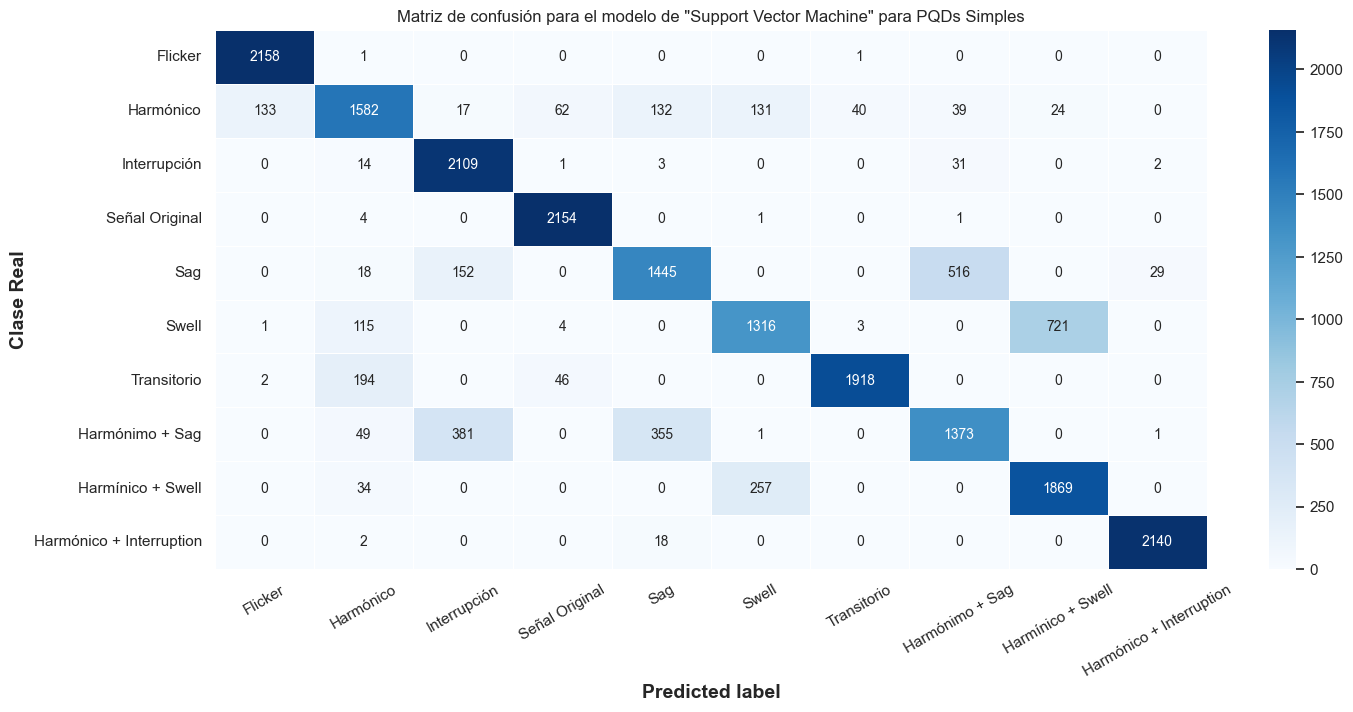

In [4]:
# Se tiene que haber cargado "confusion_matrix" desde scikit_Learn
matrix = confusion_matrix(y_test, predicciones)

# La mejor dimensión que he encontrado para que se muestre es 16x7, menor se solapan los nombres
plt.figure(figsize=(16,7))
# Simplemente dejar la escala de la fuente en un número que no sea demasiado grande
sns.set(font_scale=1)
# importante fmt = 'd', si no, lo valores se mostrarán porcentualmente. cmap Blues porque me gusta el azul.
sns.heatmap(matrix, annot=True, annot_kws={'size':10},fmt= 'd' ,cmap=plt.cm.Blues, linewidths=0.5)

# Add labels to the plot
class_names = ['Flicker', 'Harmónico', 'Interrupción', 'Señal Original', 'Sag', 'Swell','Transitorio',"Harmónimo + Sag","Harmínico + Swell", "Harmónico + Interruption"]
tick_marks = np.arange(len(class_names)) + 0.5
tick_marks2 = tick_marks
plt.xticks(tick_marks, class_names, rotation=30)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label', weight='bold', fontsize=14)
plt.ylabel('Clase Real', weight='bold', fontsize=14)
plt.title('Matriz de confusión para el modelo de "Support Vector Machine" para PQDs Simples')
plt.show()